# FineTuning BERT for Multi-Class Classification with custom datasets

In [1]:
import torch, os
from google.colab import drive
drive.mount('/content/drive')
if os.getcwd() != "/content/drive/My Drive/akademi/Packt NLP with Transformers/CH05":
  os.chdir("drive/MyDrive/akademi/Packt NLP with Transformers/CH05")

Mounted at /content/drive


In [2]:
!pip install transformers datasets

     |████████████████████████████████| 2.5MB 14.6MB/s 
     |████████████████████████████████| 245kB 56.1MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 901kB 40.4MB/s 
     |████████████████████████████████| 122kB 56.1MB/s 
     |████████████████████████████████| 245kB 59.2MB/s 


## Loading Pre-Trained Model

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Obtaining and Preparing downstream task data

In [4]:
if "TTC4900.csv" not in os.listdir():
 !wget  https://raw.githubusercontent.com/savasy/TurkishTextClassification/master/TTC4900.csv
else:
   print("Already there !")

Already there !


In [6]:
import pandas as pd
data= pd.read_csv("TTC4900.csv")
data=data.sample(frac=1.0, random_state=42)
data.head(5)

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


In [7]:
labels=["teknoloji","ekonomi","saglik","siyaset","kultur","spor","dunya"]
NUM_LABELS= len(labels)
id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

In [8]:
label2id

{'dunya': 6,
 'ekonomi': 1,
 'kultur': 4,
 'saglik': 2,
 'siyaset': 3,
 'spor': 5,
 'teknoloji': 0}

In [9]:
data["labels"]=data.category.map(lambda x: label2id[x.strip()])

In [10]:
data.head()

,category,text,labels
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,5
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,6
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,5


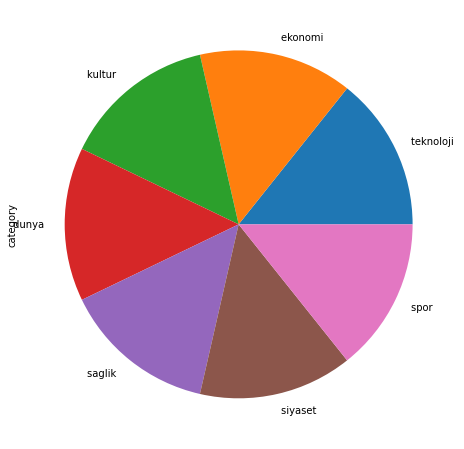

In [11]:
data.category.value_counts().plot(kind='pie', figsize=(8,8))

In [12]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)

In [13]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Splitting data


In [14]:
SIZE= data.shape[0]

train_texts= list(data.text[:SIZE//2])
val_texts=   list(data.text[SIZE//2:(3*SIZE)//4 ])
test_texts=  list(data.text[(3*SIZE)//4:])

train_labels= list(data.labels[:SIZE//2])
val_labels=   list(data.labels[SIZE//2:(3*SIZE)//4])
test_labels=  list(data.labels[(3*SIZE)//4:])

In [15]:
len(train_texts), len(val_texts), len(test_texts)

(2450, 1225, 1225)

In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [17]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [18]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

## Training with Trainer Class

In [19]:
from transformers import TrainingArguments, Trainer

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    return { 
        'Accuracy': acc, 
        'F1': f1, 
        'Precision': precision, 
        'Recall': recall 
    } 

In [21]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="epoch", 
    fp16=True,
    load_best_model_at_end=True
)

In [22]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics= compute_metrics
)

Using amp fp16 backend


In [23]:
trainer.train()

***** Running training *****
  Num examples = 2450
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 462


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.850700,1.507407,0.624490,0.608790,0.740980,0.627075
100,0.733500,0.365703,0.895510,0.896049,0.906131,0.896706
150,0.361300,0.306502,0.908571,0.908585,0.910181,0.908059
200,0.262900,0.318767,0.905306,0.905354,0.909020,0.905336
250,0.159000,0.324903,0.915102,0.915583,0.918657,0.915158
300,0.227400,0.331741,0.920000,0.918919,0.921991,0.919482
350,0.078200,0.351717,0.921633,0.921153,0.921619,0.921414
400,0.087700,0.338882,0.919184,0.919011,0.919340,0.918896
450,0.084000,0.326685,0.923265,0.922903,0.922840,0.923093


/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1299: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
Saving model checkpoint to ./TTC4900Model/checkpoint-50
Configuration saved in ./TTC4900Model/checkpoint-50/config.json
Model weights saved in ./TTC4900Model/checkpoint-50/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
Saving model checkpoint to ./TTC4900Model/checkpoint-100
Configuration saved in ./TTC4900Model/checkpoint-100/config.json
Model weights saved in ./TTC4900Model/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
Savi

TrainOutput(global_step=462, training_loss=0.4197033045095799, metrics={'train_runtime': 700.7851, 'train_samples_per_second': 10.488, 'train_steps_per_second': 0.659, 'total_flos': 2497772677478400.0, 'train_loss': 0.4197033045095799, 'epoch': 3.0})

In [24]:
q=[trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

***** Running Evaluation *****
  Num examples = 2450
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1225
  Batch size = 32


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.197921,0.941633,0.941545,0.942952,0.941139
val,0.306502,0.908571,0.908585,0.910181,0.908059
test,0.318877,0.908571,0.908620,0.908974,0.909747


In [25]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [26]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

In [27]:
# Example #1
text = "Fenerbahçeli futbolcular kısa paslarla hazırlık çalışması yaptılar"
predict(text)

(tensor([[0.0043, 0.0068, 0.0075, 0.0047, 0.0077, 0.9663, 0.0026]],
        device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor(5, device='cuda:0'),
 'spor')

## Save and Re-Load saved model for inference

In [28]:
!pip install transformers

In [29]:
# saving the fine tuned model & tokenizer
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

Saving model checkpoint to turkish-text-classification-model
Configuration saved in turkish-text-classification-model/config.json
Model weights saved in turkish-text-classification-model/pytorch_model.bin
tokenizer config file saved in turkish-text-classification-model/tokenizer_config.json
Special tokens file saved in turkish-text-classification-model/special_tokens_map.json


('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

In [30]:
model_path = "turkish-text-classification-model"
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

loading configuration file turkish-text-classification-model/config.json
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "teknoloji",
    "1": "ekonomi",
    "2": "saglik",
    "3": "siyaset",
    "4": "kultur",
    "5": "spor",
    "6": "dunya"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "dunya": 6,
    "ekonomi": 1,
    "kultur": 4,
    "saglik": 2,
    "siyaset": 3,
    "spor": 5,
    "teknoloji": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.

In [31]:
nlp("Sinemada hangi filmler oynuyor bugün")

[{'label': 'kultur', 'score': 0.897723913192749}]

In [32]:
nlp("Dolar ve Euro bugün yurtiçi piyasalarda yükseldi")

[{'label': 'ekonomi', 'score': 0.9639127254486084}]

In [33]:
nlp("Bayern Münih ile Barcelona bugün karşı karşıya geliyor. Maçı İngiliz hakem James Watts yönetecek!")

[{'label': 'spor', 'score': 0.9791778922080994}]